This script uses precalculated AgingList file.
Run make_aging_list.py first if you do not have it.

It also uses the file with differentially expressed genes, which you want to test on how well it fits to the aging signature. 

First, import nesessary packages and the AginList from file. It can be either 
Aging_list_META.txt (for meta data) or Aging_list_REAN.txt (for reanalyzed data).

In [2]:
import matplotlib.pyplot as plt, scipy.stats as ss, numpy as np

"input file with precalculated signature gene list"
f_in=open("Aging_list_META.txt","r") #or Aging_list_REAN.txt
lines=f_in.readlines()
f_in.close()
#split lines by proper separator: \t for tabs, otherwise modify split symbol below accordingly
items=[line.rstrip().split("\t") for line in lines[1:]]
#collect gene names and citation frequencies, logFC values are not used here, therefore not collected
names, freqs =[x[0] for x in items], [int(x[1]) for x in items]
#sort lists
sort=sorted(zip(freqs,names), reverse=True)

Check the macimal citation value, which is the first freq on the list
Also check the total list size by calling its length

In [3]:
mymax=sort[0][0]
print("mymax and all list",mymax, len(sort))

mymax and all list 9 6314


Split zipped list on GeneScore (a.k.a. citation value) and Genes (gene names)

In [ ]:
"Split sort list on gene names and gene scores"
GeneScore, Genes =[x[0] for x in sort], [x[1] for x in sort]

you can check what you got, or skip it

In [6]:
print("GeneScore", len(GeneScore))#, GeneScore) #a.k.a. rank score
print("Genes", len(Genes))#, Genes)

GeneScore 6314
Genes 6314


We will need to make so-called control points, which will be used to generate a dGSE plot.
These are cumulative values of gene numbers with citation index above the threshold, the threshold is floating for every index value from 1 to maximum of citation index on the list

In [9]:
print("make control points for DGSE plot")
controls=[]
for i in range(0,max(GeneScore)):
    controls.append(len([x for x in GeneScore if x>i]))
control_points=controls[::-1] #reverse order
print(control_points) #[1, 4, 7, 16, 22, 57, 103, 185, 344, 875, 4024]
print(control_points[-1])
print("calculate cumulative % in control points")
for i in range(len(control_points)):
    print(len(control_points)-i, control_points[i], control_points[i]*100/control_points[-1])

make control points for DGSE plot
[1, 2, 4, 15, 52, 142, 383, 1306, 6314]
6314
calculate cumulative % in control points
9 1 0.015837820715869498
8 2 0.031675641431738996
7 4 0.06335128286347799
6 15 0.23756731073804244
5 52 0.8235666772252138
4 142 2.2489705416534687
3 383 6.0658853341780175
2 1306 20.684193854925564
1 6314 100.0


We empirically define the control point at which we will later calculate the enrichment coefficient. For META data we can choose either all genes with GEneScore>3 (2.25%), or GeneScore>2 (6.07%). So we set a threshold at 142 genes cumulative

In [26]:
thresh=142

Next, we open a file with the list of differentially expressed genes. For this analysis we only need gene names. Here we take one example from meta data.

In [15]:
"single file for dGSE plot"
mdir="/Users/leonid_bystrykh/Documents/Articles&Presentations/2020/AgingSign/data/meta/"
mfile="Noda_2009.txt"
f_in=open(mdir+mfile,"r")
lines=f_in.readlines()
f_in.close()
names=[]
for line in lines[2:]:
    items=line.rstrip().replace(" ","").split("\t")
    item=items[1].split("///")
    names.append(item[0])

Let's how many gene names are there, and print first 5 or them

In [16]:
print("Names in loaded file", len(names), names[:5])

Names in loaded file 168 ['1190002H23Rik', 'Apbb2', 'Cadm1', 'Cdkn1a', 'Cdkn2c']


Next, for all genes on the list we calculate their indexes in the AgingList
Also we collect all scores from AgingList for all loaded genes. If gene from the loaded file is not on the AgingList, we assign 0 value

In [17]:
shortlist,scores=[],[] #gene indexes and scores
for name in names:
    if name in Genes:
        shortlist.append(Genes.index(name))
        scores.append(GeneScore[Genes.index(name)])
    else:
        scores.append(0) #unlisted genes go to the score 0
        

We can check the list of scores

In [ ]:
print("check genes and scores found")
for i in range(mymax+1):
    print(i, scores.count(i))

Now we calculate the rank score, one of two scores we use in the manuscript.

In [18]:
"count rank score" #add all scores if >1, subtract all scores==1
RankScore=0
for s in scores:
    if s>1:
        RankScore+=s
    else:
        RankScore -=1
print("Rank Score for ", mfile, " is ", RankScore)

Rank Score for  Noda_2009.txt  is  393


Finally, we calculate enrichment scores for all control points (it can be used for graphic representation of the score)

In [30]:
"make cumulative curve"
observed,expected,delta,fisher=[],[],[],[]
print("Full list", len(shortlist))
print("Ctl_p\texpc\tobsd\tEnScore\tFisher_p")
for i in control_points:
       # found = [x for x in shortlist if x < i]
        found=[x for x in names if x in Genes[:i]]
      #  print(i, "found", len(found))
        observe = (len(found))
        observed.append(observe)
        expect = len(shortlist) * i / len(Genes)
        expected.append(expect)
        EnScore=((observe-expect)*100/len(names))
        f_fi = ss.fisher_exact([[expect, len(shortlist) - expect], [observe, len(shortlist) - observe]])
        print(i,  int(expect), int(observe), round(EnScore,3), f_fi[1], sep="\t")
        delta.append(int(observe)-int(expect))
        #remember the result at the threshold value
        if i==thresh:
            myline=[i,  int(expect), int(observe), round(EnScore,3), f_fi[1]]

Full list 168
Ctl_p	expc	obsd	EnScore	Fisher_p
1	0	0	-0.016	1.0
2	0	0	-0.032	1.0
4	0	1	0.532	1.0
15	0	3	1.548	0.2477611940298211
52	1	20	11.081	1.2168587335786353e-05
142	3	42	22.751	6.706854278749095e-11
383	10	84	43.934	1.222482419379737e-20
1306	34	137	60.863	9.660590417614223e-31
6314	168	168	0.0	1.0


We previously agreed on the control_point of 142 genes (enrichment in window of 0-142 first genes), which means that the enrichment score is 22.751. 
We can print out the resulting Enrichment score since we remembered that line

In [29]:
print("Enrichment score for", mfile, " is ", myline[3],   sep="\t")

Enrichment score for	Noda_2009.txt	 is 	22.751


you can also make a plot of the enrichment scores. The simple version is below

Text(0, 0.5, 'Enrichment scores')

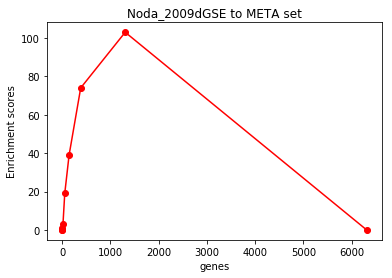

In [35]:
plt.plot(control_points, delta,"-o", c="red")
plt.title(mfile[:-4]+ " enrichment to aging META set")
plt.xlabel("genes")
plt.ylabel("Enrichment scores")